In [34]:
import numpy as np
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt
import dateutil.parser as dp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns

# Pobieranie i zapisywanie danych

In [20]:
pogoda = pd.read_html('https://weather.com/pl-PL/pogoda/dzisiaj/l/210036ee3963854e507c1fdb804560b821aa8c0a25661de14efccf0c87f7f8c0')[0]
pogoda = pogoda.T.rename(columns=pogoda.T.iloc[0]).iloc[1:]
pogoda['Data'] = datetime.datetime.date(datetime.datetime.now()).isoformat()
if os.path.isfile('pogoda.csv'):
    pogoda = pd.concat([pd.read_csv('pogoda.csv', index_col=0), pogoda], sort=False).reset_index().iloc[:, 1:]
pogoda.to_csv('pogoda.csv')


In [11]:
powietrze = pd.read_html("https://aqicn.org/city/poznan/pl/")[5]
powietrze.iloc[0,1] = datetime.datetime.date(datetime.datetime.now()).isoformat()
powietrze.rename(index=powietrze[0], columns=powietrze.iloc[0], inplace=True)
powietrze = powietrze.iloc[1:6, [1]].T.reset_index().rename(columns={'index': 'Data'})
if os.path.isfile('powietrze.csv'):
    powietrze = pd.concat([pd.read_csv('powietrze.csv', index_col=0), powietrze], sort=False).reset_index().iloc[:, 1:]
powietrze.to_csv('powietrze.csv')


# Obrabianie danych

In [10]:
pogoda = pd.read_csv('pogoda.csv', index_col=0)
pogoda.Wiatr = pogoda.Wiatr.str[-7:-4]
pogoda = pogoda.applymap(lambda x: x.replace(" ", ""))
pogoda = pogoda.applymap(lambda x: x.replace(chr(160), ""))
pogoda = pogoda.applymap(lambda x: x.replace(",", "."))
pogoda.Ciśnienie = pogoda.Ciśnienie.str[0:-4]
pogoda['Punkt rosy'] = pogoda['Punkt rosy'].str[0:-1]
pogoda.Wilgotność = pogoda.Wilgotność.str[0:-1]
pogoda.Widoczność = pogoda.Widoczność.str[0:-2]
powietrze = pd.read_csv('powietrze.csv', index_col=0)
dane = powietrze.loc[:, ['Data', 'PM2.5 AQI']].merge(pogoda).iloc[:, 1:].astype('float')


,PM2.5 AQI,Ciśnienie,Punkt rosy,Wiatr,Widoczność,Wilgotność
0,86.0,1010.8,0.0,27.0,16.1,83.0
1,86.0,1034.2,4.0,8.0,9.7,86.0
2,108.0,1031.5,1.0,6.0,6.4,94.0
3,154.0,1027.4,1.0,8.0,8.1,70.0


# Ocena danych

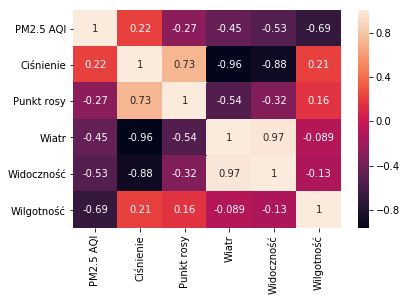

In [9]:
sns.heatmap(data=dane.corr(), annot=True)

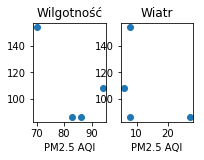

In [27]:
parametry = dane[["Wilgotność", "Wiatr"]]
wartosci = dane['PM2.5 AQI']
for i, col in enumerate(parametry):
    plt.subplot(2, len(parametry) , i+1)
    plt.scatter(parametry[col], wartosci, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.xlabel('PM2.5 AQI')

# Trenowanie modelu

In [67]:
model = LinearRegression()
pTrening, pTest, wTrening, wTest = train_test_split(parametry, wartosci, test_size=0.2, random_state=5)
model.fit(pTrening,wTrening)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Ocena modelu

In [62]:
przewidywania = model.predict(pTest)
print("Rmse: " + np.array2string(np.sqrt(mean_squared_error(wTest, przewidywania))))
print("R2: " + np.array2string(r2_score(wTest, przewidywania)))
print("Współczynnik: " + np.array2string(model.coef_))
print("Intercept: " + np.array2string(model.intercept_))

Rmse: 519.25
R2: 0.
Współczynnik: [ -4.25 -28.  ]
Intercept: 675.5
